In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input 
from tensorflow.keras.optimizers import Adam, Adamax 
from tensorflow.keras.metrics import categorical_crossentropy 
from tensorflow.keras import regularizers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Model, load_model, Sequential 
from keras.callbacks import ModelCheckpoint 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.applications import MobileNetV2 


# akses file

In [3]:
train_dir = r'train'
val_dir = r'val'
test_dir = r'test'
# membuat dataframe dari  directory
def create_dataframe_from_directory(directory):
    filepaths = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            filepaths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

# persiapan data dan augmentasi gambar warna

In [4]:
# membuat dataframes
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)

print(train_df.head(), val_df.head(), test_df.head())

# Image dimensions dan batch size
height = 224
width = 224
channels = 3
batch_size = 32

img_size = (height, width)

# menghitun test batch size
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

# Data augmentation dan normalization untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Normalization untuk validation dan testing
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)



                filepaths     labels
0  train\Andaliman\10.jpg  Andaliman
1  train\Andaliman\11.jpg  Andaliman
2  train\Andaliman\13.JPG  Andaliman
3  train\Andaliman\14.jpg  Andaliman
4  train\Andaliman\15.jpg  Andaliman               filepaths     labels
0  val\Andaliman\16.jpg  Andaliman
1  val\Andaliman\17.jpg  Andaliman
2  val\Andaliman\30.jpg  Andaliman
3  val\Cabe jawa\16.jpg  Cabe jawa
4  val\Cabe jawa\17.jpg  Cabe jawa                filepaths     labels
0   test\Andaliman\1.jpg  Andaliman
1  test\Andaliman\12.jpg  Andaliman
2  test\Andaliman\28.jpg  Andaliman
3   test\Cabe jawa\1.jpg  Cabe jawa
4  test\Cabe jawa\12.jpg  Cabe jawa
test batch size: 23 test steps: 1
Found 166 validated image filenames belonging to 7 classes.
Found 19 validated image filenames belonging to 7 classes.
Found 23 validated image filenames belonging to 7 classes.
['Andaliman', 'Cabe jawa', 'Cengkeh', 'Kapulaga', 'Kayu manis', 'Lada', 'Pala']


# membuat model 

In [5]:

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       304,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,612,859 (17.60 MB)

 Trainable params: 343,143 (1.31 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

# melatih model

In [6]:
epochs =100
history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test accuracy: {test_acc}')

d:\Projek\TF_gambarBumbuDapur\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1602 - loss: 1.9475 - val_accuracy: 0.1579 - val_loss: 1.9338
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step - accuracy: 0.1963 - loss: 1.9334 - val_accuracy: 0.2632 - val_loss: 1.9174
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 746ms/step - accuracy: 0.2473 - loss: 1.9059 - val_accuracy: 0.2105 - val_loss: 1.9024
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - accuracy: 0.1997 - loss: 1.9111 - val_accuracy: 0.4211 - val_loss: 1.8859
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step - accuracy: 0.2772 - loss: 1.8655 - val_accuracy: 0.3684 - val_loss: 1.8533
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 867ms/step - accuracy: 0.2369 - loss: 1.8521 - val_accuracy: 0.4211 - val_loss: 1.8268
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 759ms/step - accuracy: 0.3551 - loss: 1.8140 - val_accuracy: 0.4211 - val_loss: 1.7943
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 747ms/step - accuracy: 0.3614 - loss: 1.7973 - val_accuracy: 0.5263 - val

# membuat analisa model atau laporan hasil model

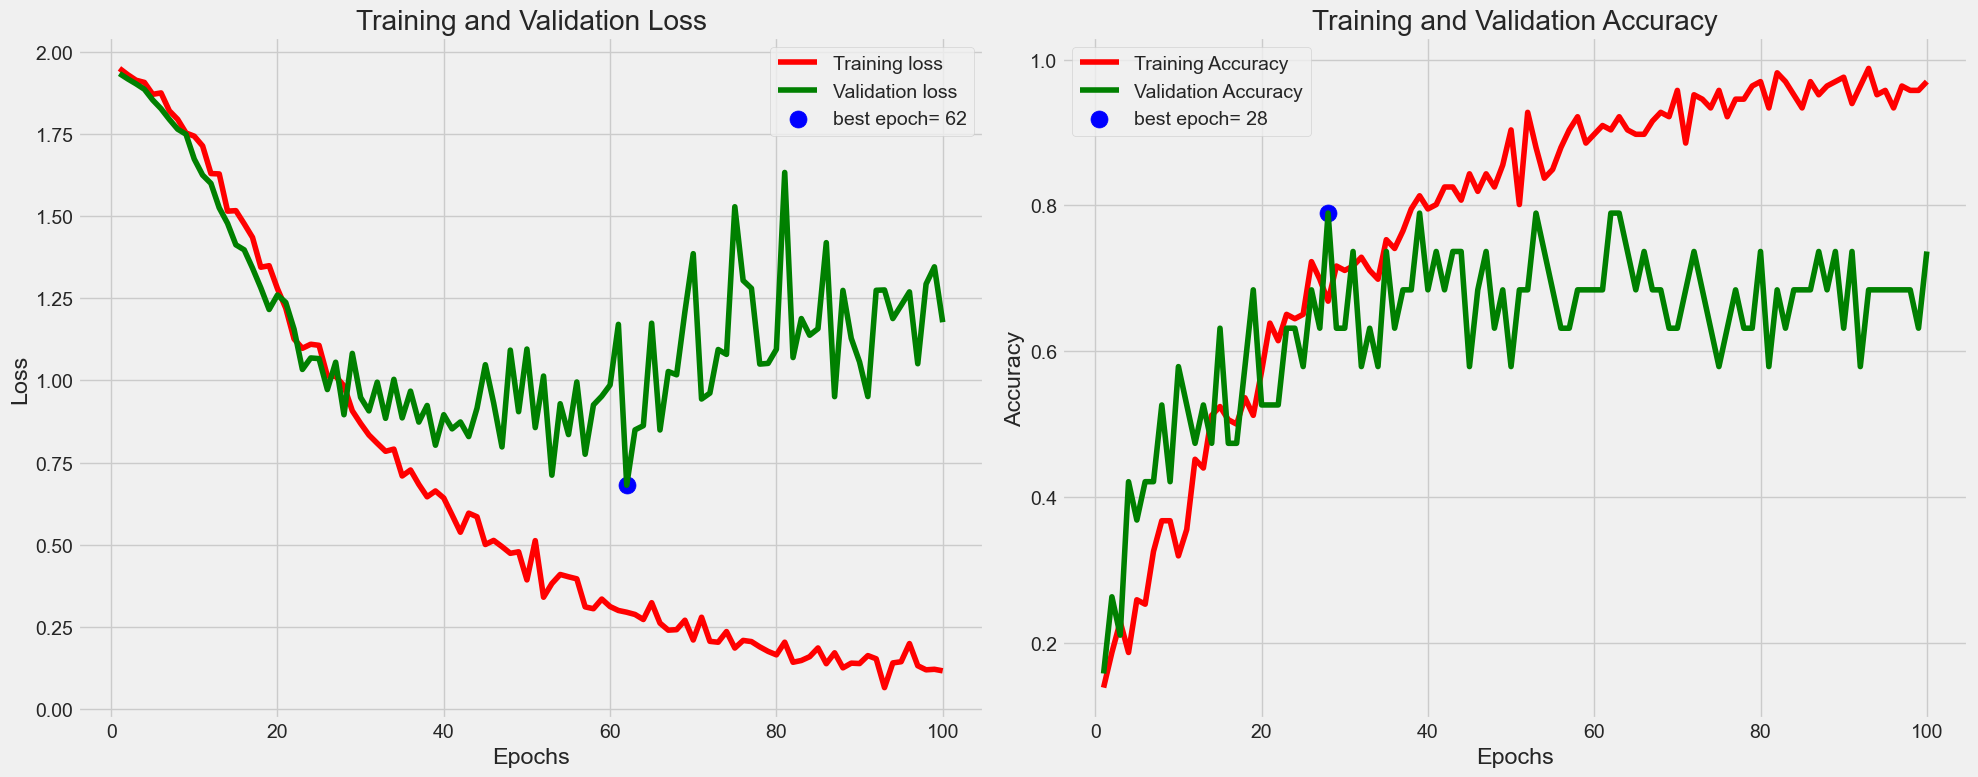

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7391 - loss: 0.9191
accuracy on the test set is 73.91 %

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


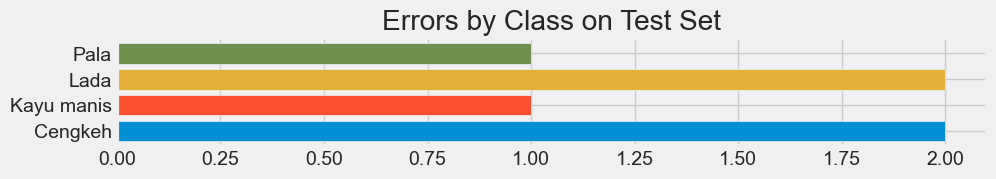

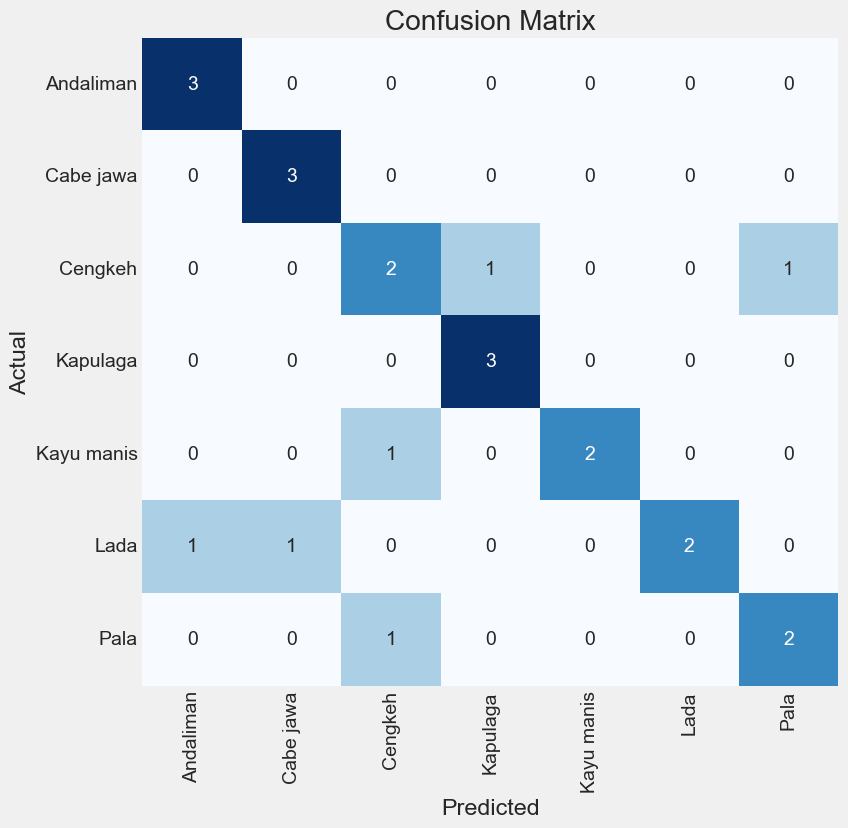

Classification Report:
----------------------
               precision    recall  f1-score   support

   Andaliman       0.75      1.00      0.86         3
   Cabe jawa       0.75      1.00      0.86         3
     Cengkeh       0.50      0.50      0.50         4
    Kapulaga       0.75      1.00      0.86         3
  Kayu manis       1.00      0.67      0.80         3
        Lada       1.00      0.50      0.67         4
        Pala       0.67      0.67      0.67         3

    accuracy                           0.74        23
   macro avg       0.77      0.76      0.74        23
weighted avg       0.77      0.74      0.73        23



In [7]:
def tr_plot(tr_data, start_epoch):

    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

def print_in_color(txt_msg, fore_tupple, back_tupple):

    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)
    return

def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        new_dict[value] = key
    classes = list(new_dict.values())
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x, )
            plt.title('Errors by Class on Test Set')
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

model_name = 'my_model'

tr_plot(history, 0)

save_dir = r'./'
subject = 'pest'
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.keras')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)
print_code = 0
preds = model.predict(test_gen)
print_info(test_gen, preds, print_code, save_dir, subject)

# mengetes model 

In [6]:
import tensorflow as tf
import cv2
import numpy as np

# Load TensorFlow model
model_path = 'my_model-pest-73.91.keras'  # Path ke model yang sudah disimpan
model = tf.keras.models.load_model(model_path)

# Peta indeks kelas ke label nama kelas
class_labels = {
    0: "Kapulaga",
    1: "Cabai jawa",
    2: "Andaliman",
    3: "Cengkeh",
    4: "Kayu manis",
    5: "Lada",
    6: "Pala ",
}

# Load dan preprocess gambar
image_path = '12.jpg'  # Path ke gambar
input_size = (224, 224)  # Sesuaikan dengan ukuran input model

# Baca gambar
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not open image file {image_path}")
    exit()

# Resize gambar sesuai dengan input model
resized_image = cv2.resize(image, input_size)

# Preprocessing 
input_image = np.expand_dims(resized_image, axis=0)  # Tambahkan dimensi batch

# Normalisasi gambar ke range [0, 1] 
input_image = input_image / 255.0  

# Lakukan prediksi
predictions = model.predict(input_image)

# Cek hasil prediksi dalam bentuk probabilitas untuk setiap kelas
print(f"Predictions: {predictions[0]}")

predicted_class = np.argmax(predictions[0], axis=-1)
confidence = np.max(predictions[0])  # Confidence tertinggi

# Ambil label kelas yang diprediksi
predicted_label = class_labels.get(predicted_class, "Unknown")

# Tampilkan hasil prediksi
print(f"Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

# Tampilkan gambar dan hasil prediksi
# Baris pertama (kelas)
cv2.putText(image, f"Class: {predicted_label}", (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)

# Baris kedua (confidence)
cv2.putText(image, f"Conf: {confidence:.2f}", (10, 70), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)


cv2.imshow('Predicted Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions: [1.0343740e-03 1.3575806e-05 3.4714199e-04 1.1936303e-03 9.9661332e-01
 6.8091627e-05 7.2994217e-04]
Predicted class: Kayu manis, Confidence: 1.00
